# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data transformation

In [4]:
shift = 200
ylog=np.log1p(data_train_raw['loss']+shift)
## ymean=ylog.mean()
## ystd=ylog.std()
ymean=ylog.min()
ystd=ylog.max()-ymean
data_train_raw['loss_g']=(ylog-ymean)/ystd
# data_train_raw['loss_g']=ylog

In [5]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: 0.389725739865
Std of log1py: 0.114276556585
Lower clipping bound: 0.0468960701107
Upper clipping bound: 0.732555409619
Shape of cleaned data: (187994, 133)


In [6]:
# # rescale cleaned data
# ymean=data_train_raw['loss_g'].min()
# ystd=data_train_raw['loss_g'].max()
# data_train_raw['loss_g']=(ylog-ymean)/(ystd-ymean)

In [7]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

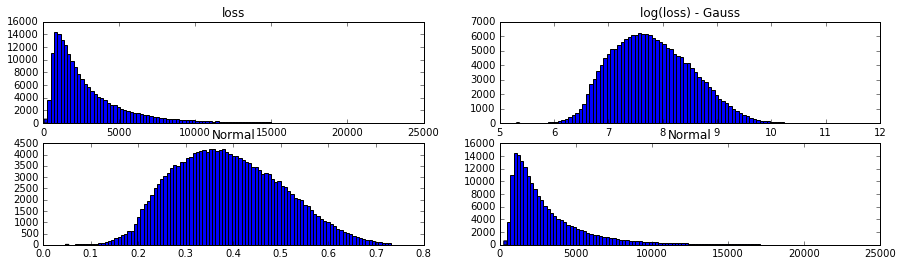

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# Data preparation - continuous variables

In [9]:
# f130, f100, f123, f112 top 4 variables
# f101, f124, f118, f122, f121
# f117, f113, f120, f119, f110
# f129, f114, f126, f103, f127, f125, f111, f91, f116, f128, f82, f83, f80, f79, f81, f108

In [10]:
# # f130 - cont14
# catName = 'cont14'
# varOrg = data_train_raw[catName]
# varTran = np.log(2*np.pi*data_train_raw[catName])
# plt.figure(figsize=(15,14))
# plt.subplot(2,2,1)
# plt.hist(varOrg,100);
# plt.subplot(2,2,2)
# plt.hist(varTran,100);
# plt.subplot(2,2,3)
# plt.scatter(varOrg,data_train_raw['loss_g']);
# plt.subplot(2,2,4)
# plt.scatter(varTran,data_train_raw['loss_g']);


# Data preparation - labeling encoder

In [11]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [12]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313540, 130)
(313540, 116) of which are categorical
(313540, 14) of which are continuous


In [13]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [14]:
# LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x
        
# dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
# dataCatAll.head()

In [15]:
features = dataCatAll.columns[0:]
dataCatAll_2 = dataCatAll[features]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll_2[feat] = pd.factorize(dataCatAll_2[feat], sort=True)[0]
dataCatAll_2.head()
# le.classes_

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,46,28,2,19,57,0,14,287
1,0,1,0,0,0,0,0,0,1,1,...,10,10,34,67,0,22,39,0,14,94
2,0,1,0,0,1,0,0,0,1,1,...,5,0,2,87,0,28,6,0,8,167
3,1,1,0,1,0,0,0,0,1,0,...,10,10,34,69,2,39,5,0,14,88
4,0,1,0,1,0,0,0,0,1,1,...,6,1,67,51,2,50,39,0,10,63


#  Data preparation - cat variables

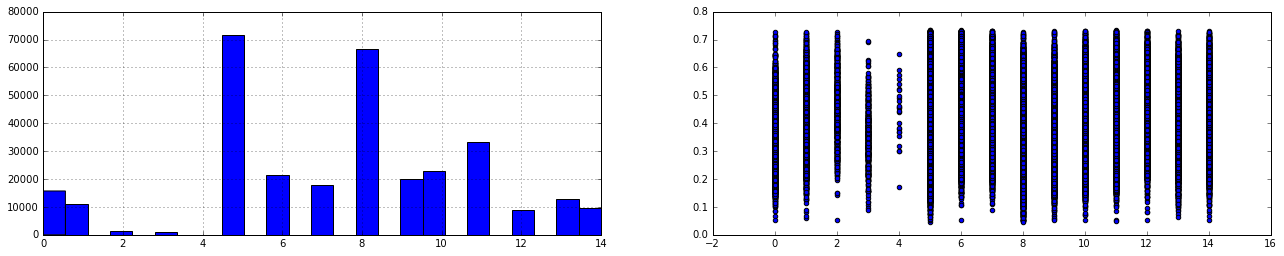

In [16]:
# f130 - cat100
# merge E, C into M, D into O
catName = 'cat100'
varOrg = dataCatAll_2[catName]
varLossg = labelSs
plt.figure(figsize=(22,4))
plt.subplot(1,2,1)
varOrg.hist(bins=25)
plt.subplot(1,2,2)
plt.scatter(varOrg.iloc[0:len(varLossg)], varLossg)

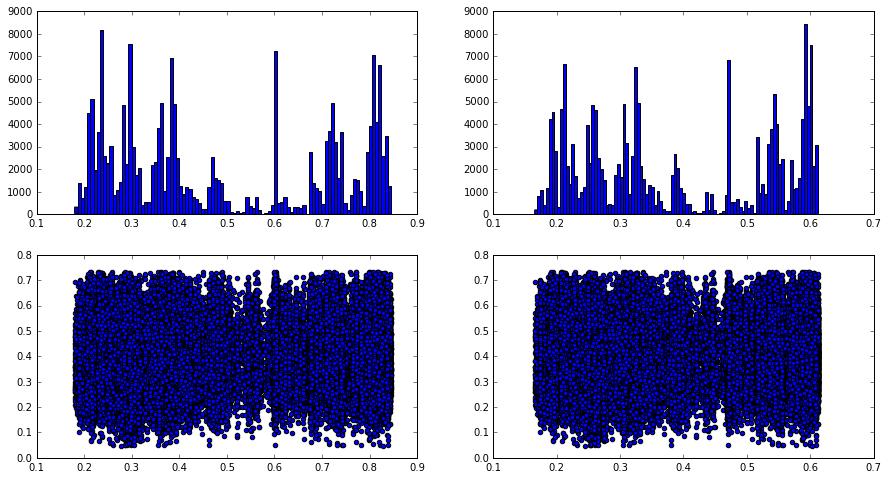

In [17]:
# cont14
catName = 'cont14'
varOrg = data_train_raw[catName]
varTran = np.log1p(data_train_raw[catName])
# varTran = np.cos(2*np.pi*data_train_raw[catName])
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.hist(varOrg,100);
plt.subplot(2,2,2)
plt.hist(varTran,100);
plt.subplot(2,2,3)
plt.scatter(varOrg,data_train_raw['loss_g']);
plt.subplot(2,2,4)
plt.scatter(varTran,data_train_raw['loss_g']);
# data_train_raw[catName] = varTran

In [18]:
# dataCatAll = dataCatAll.drop(features,axis=1)
# dataCatAll.head()

In [19]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# for col in dataCatAll.columns:
#     if (col.find('cat') !=-1):
# #        print(col)
#         dataCatAll[col]=le.fit_transform(dataCatAll[col])
# #         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
# #         le.classes_ = np.append(le.classes_, '<unknown>')
# #         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
# print(dataCatAll.columns)


In [20]:
# dataCatAll.head()

In [21]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll_2 = mms.fit_transform(dataCatAll_2)

In [22]:
print(x_catAll_2.shape)
x_catAll_2

(313540, 116)


array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.82947977],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.2716763 ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.36363636,  0.48265896],
       ..., 
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.68181818,  0.89595376],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.25433526],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.5       ,  0.20231214]])

# one-hot-encoding - skipped in order to keep the alphabetical order

In [23]:
# # one-hot-encoding the categorical features
# enc = preprocessing.OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# rescale continuous features

In [24]:
for col in dataFltAll.columns:
    dataFltAll[col] = np.log1p(dataFltAll[col])

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
# from sklearn.preprocessing import MinMaxScaler
# mms_2 = MinMaxScaler()
# x_fltAll = mms_2.fit_transform(dataFltAll)

# split x_train and x_test

In [26]:
# x_catAll_2.shape
# x_fltAll.shape
# x_Train

In [27]:
# # split x_train and x_test
# x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
# x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:],x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
# y_Train = labelSs.values

# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# # split x_train and x_test
# x_Train = np.hstack((x_catAll_2[0:len(labelSs),:],x_fltAll[0:len(labelSs),:]))
# x_Test = np.hstack((x_catAll_2[len(labelSs):,:],x_fltAll[len(labelSs):,:]))
# y_Train = labelSs.values

# check the dimension of prepared data

In [28]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 130)
(187994, 130)
(187994,)


# splite the training data for valication

In [29]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150395, 130)
(150395,)
(37599, 130)
(37599,)


In [30]:
del x_Train
del y_Train
del x_catAll_2
del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [31]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [32]:
# testList = ['XGBoostTrees', 'AdaBoosting', 'MLPRegressor','Ensemble']
testList = ['XGBoostTrees','Ensemble']

### Ridge Regression

In [33]:
# from sklearn.linear_model import RidgeCV
# # from sklearn.linear_model import Ridge

In [34]:
# cv = 3
# # alphas = (1e-2,1e-1,1,1e1,1e2)
# # alphas = (5,20,30,40)
# alphas = [10]
# regCV = RidgeCV(cv=cv,alphas = alphas)
# regCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(regCV.alpha_))
# # print('cv_values_: {}\n'.format(regCV.cv_values_))

In [35]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

In [36]:
# y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### Lasso Regression

In [37]:
# from sklearn.linear_model import LassoCV

In [38]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [39]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [40]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [41]:
# from sklearn.ensemble import RandomForestRegressor

In [42]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [43]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [44]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [45]:
import xgboost as xgb

In [ ]:
# d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
# d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
# x_val_xgb = xgb.DMatrix(x_val.tocsc())
# d_test_xgb = xgb.DMatrix(x_Test.tocsc())

d_train_xgb = xgb.DMatrix(x_train,label=y_train)
d_val_xgb = xgb.DMatrix(x_val,label = y_val)
x_val_xgb = xgb.DMatrix(x_val)
d_test_xgb = xgb.DMatrix(x_Test)

In [ ]:
num_round = 100000

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0,'eta':0.05,'min_child_weight':0}
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1117, 2950 rounds
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.001,'min_child_weight':0,'subsample':0.8}

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-mae:0.133935	train-mae:0.133203
[1]	eval-mae:0.133834	train-mae:0.133102
[2]	eval-mae:0.133733	train-mae:0.133001
[3]	eval-mae:0.133632	train-mae:0.1329
[4]	eval-mae:0.13353	train-mae:0.132799
[5]	eval-mae:0.133429	train-mae:0.132698
[6]	eval-mae:0.133329	train-mae:0.132597
[7]	eval-mae:0.133228	train-mae:0.132497
[8]	eval-mae:0.133127	train-mae:0.132396
[9]	eval-mae:0.133027	train-mae:0.132296
[10]	eval-mae:0.132927	train-mae:0.132196
[11]	eval-mae:0.132827	train-mae:0.132096
[12]	eval-mae:0.132727	train-mae:0.131997
[13]	eval-mae:0.132627	train-mae:0.131897
[14]	eval-mae:0.132528	train-mae:0.131797
[15]	eval-mae:0.132429	train-mae:0.131698
[16]	eval-mae:0.132329	train-mae:0.131599
[17]	eval-mae:0.13223	train-mae:0.1315
[18]	eval-mae:0.132131	train-mae:0.131401
[19]	eval-mae:0.132032	train-mae:0.131302
[20]	eval-mae:0.131933	train-mae:0.131203
[21]	eval-mae:0.131834	train-mae:0.131104
[22]	eval-mae:0.131735	train-mae:0.131006
[23]	eval-mae:0.131637	train-mae:0.130908
[24]	eva

In [ ]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

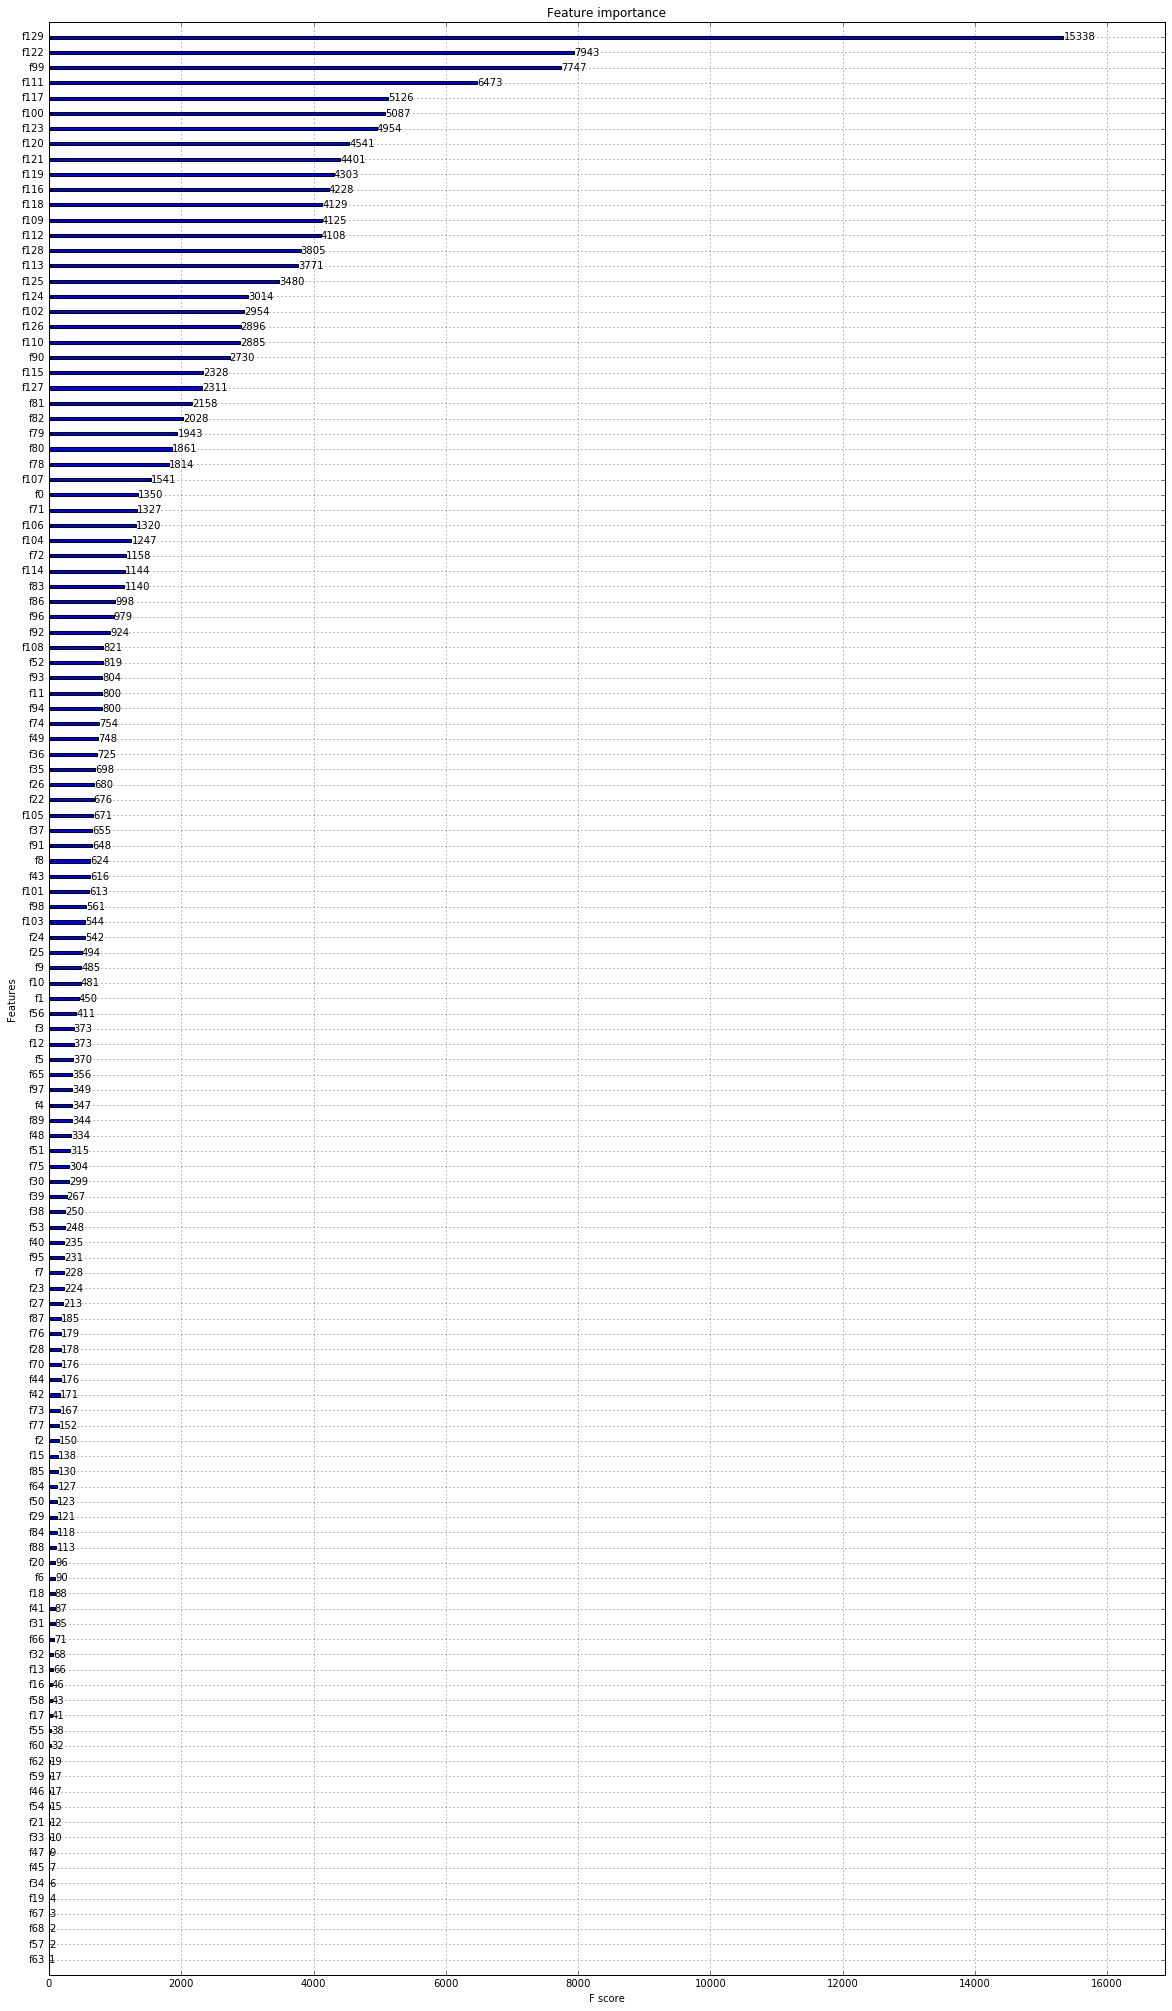

In [49]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() )

In [50]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

### AdaBoost Regression

In [51]:
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.linear_model import Ridge

In [52]:
# # n_estimators = [7,15,30, 60, 90, 120]
# # n_estimators = [10,20,30,40]
# n_estimators = [6]
# base_estimator = Ridge(alpha = 40)
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
# #     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
#     tmpAdReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         AdReg = tmpAdReg
#         n_estimator = n_est
#         err = err_i

In [53]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

In [54]:
# y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd))

### Skipped - K Nearest Neighbors

In [55]:
# from sklearn.neighbors import KNeighborsRegressor

In [56]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [57]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [58]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### Linear SVR

In [59]:
# from sklearn.svm import LinearSVR

In [60]:
# # SVReg = svm.SVR(kernel = 'rbf')
# # SVReg.fit(x_train,y_train)
# SVReg = LinearSVR(C=0.5)
# SVReg.fit(x_train,y_train)

In [61]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [62]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [63]:
# from sklearn.neural_network import MLPRegressor

In [64]:
# MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
# MLPReg.fit(x_train,y_train)

In [65]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

In [66]:
# y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd))

# save files for submission

In [67]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

The loss of the ensembled result:


1071.8210872055406

In [68]:
# remove the shift
y_pred = [y_array-shift for y_array in y_pred];
y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [69]:
y_pred

[array([ 1387.67480469,  2157.86743164,  9073.58007812, ...,  2534.45214844,
         1168.39868164,  2776.47753906], dtype=float32),
 array([ 1387.67480469,  2157.86743164,  9073.58007812, ...,  2534.45214844,
         1168.39868164,  2776.47753906], dtype=float32)]

In [70]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [71]:
from sklearn.externals import joblib
joblib.dump([gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

NameError: name 'AdReg' is not defined

In [ ]:
testList
